# Zeroth Pipeline

This pipeline compares zeroth order GD against standard GD. Three different zeroth order approximations --- one difference, two difference, and coordinate --- are tested.

### Imports

In [1]:
import os
import sys

p = os.path.abspath('../src/')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time

from difference_methods import one_point_estimate, two_point_estimate, coordinate_estimate
from linear_zeroth_function import Linear_Zeroth
from relu_zeroth_function import ReLU_Zeroth

## Data preprocessing

In [3]:
proper_test = False # For testing the pipeline using iris instead of pendigits

if proper_test:
    data_train = data_train = pd.read_csv('../data/pendigits.csv')
else:
    data_train = pd.read_csv('../data/iris_train.csv')

print(data_train)

     sepal_length  sepal_width  petal_length  petal_width          species
0             5.1          3.4           1.5          0.2      Iris-setosa
1             6.3          2.5           5.0          1.9   Iris-virginica
2             5.9          3.0           4.2          1.5  Iris-versicolor
3             5.7          2.6           3.5          1.0  Iris-versicolor
4             7.7          2.8           6.7          2.0   Iris-virginica
..            ...          ...           ...          ...              ...
115           5.6          2.5           3.9          1.1  Iris-versicolor
116           6.4          2.9           4.3          1.3  Iris-versicolor
117           7.9          3.8           6.4          2.0   Iris-virginica
118           5.4          3.0           4.5          1.5  Iris-versicolor
119           5.5          3.5           1.3          0.2      Iris-setosa

[120 rows x 5 columns]


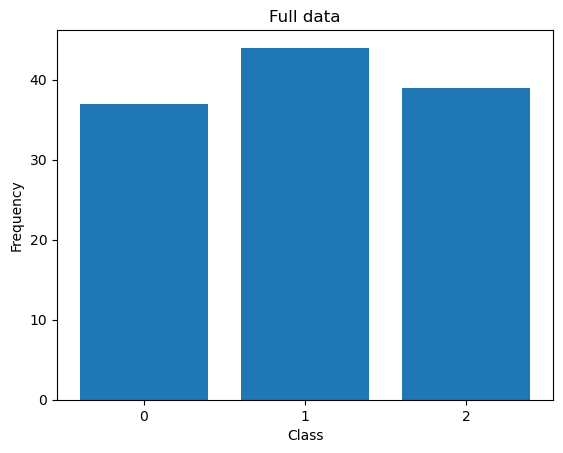

In [4]:
if proper_test:
    # extract frequency of each class
    class_freq = data_train['class'].value_counts()
else:
    # Convert string target values to numeric values
    #       class 0: Iris-setosa
    #       class 1: Iris-versicolor
    #       class 2: Iris-virginica
    data_train['species'] = data_train['species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
    # also convert all string numeric values to float ['2' -> 2.0]
    data_train = data_train.apply(pd.to_numeric)
    # extract frequency of each species class
    class_freq = data_train['species'].value_counts()

class_freq = list(class_freq.sort_index())
nb_classes = len(class_freq)
nb_features = data_train.shape[1]-1

# Visual data
graph = plt.bar(list(range(nb_classes)), class_freq)
plt.xticks(list(range(nb_classes)))
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Full data')

plt.show() # balanced data set

In [5]:
# Preprocess data for training

# Convert pandas dataframe to array
data_train_array = data_train.values

# Split x (features) and y (targets)
x_array = data_train_array[:, :nb_features]
y_array = data_train_array[:, nb_features]

# Tensorify
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

print(X.shape)

torch.Size([120, 4])


## Network Setup

In [6]:
# INPUT/OUTPUT layer sizes
INPUT_NEURONS = nb_features
OUTPUT_NEURONS = nb_classes

In [7]:
# Network architectures: 1 hidden layer

# Normal network with relu
def create_standard_relu_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        torch.nn.Linear(INPUT_NEURONS, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, OUTPUT_NEURONS)
    )

# Full Zeroth Order relu
def create_zeroth_relu_network(hidden_neurons, mu, n, difference_method):
    torch.manual_seed(1) # so that same network init with same weights at each creation
    return torch.nn.Sequential(
        Linear_Zeroth(INPUT_NEURONS, hidden_neurons, bias=False, difference_method=difference_method, mu=mu, n=n),
        ReLU_Zeroth(difference_method=difference_method, mu=mu, n=n),
        Linear_Zeroth(hidden_neurons, OUTPUT_NEURONS, bias=False, difference_method=difference_method, mu=mu, n=n),
)

networks_funs = [
    ("standard_relu", create_standard_relu_network),
    ("zeroth_relu", create_zeroth_relu_network),
]

## Train and Plot Losses

In [8]:
# Plot or save? False => Save
plot = False
path = "plots/"

# Plotting
colours = ["black", "red", "darkblue", "green", "violet",]
linestyles = ['solid', 'dashdot', 'dashed', 'dotted']

### Dimensionality vs Time

In [9]:
# Training constants
LR = 0.01
NUM_EPOCH = 100
BATCH_SIZE = 32

# Loss function
loss_func = torch.nn.CrossEntropyLoss()

# Test Variables
hidden_neurons_range = [min(INPUT_NEURONS, OUTPUT_NEURONS), max(INPUT_NEURONS, OUTPUT_NEURONS), 2*max(INPUT_NEURONS, OUTPUT_NEURONS), 4*max(INPUT_NEURONS, OUTPUT_NEURONS), 8*max(INPUT_NEURONS, OUTPUT_NEURONS), 16*max(INPUT_NEURONS, OUTPUT_NEURONS)]
MU = 0.01
N = 1000

# Methods
dimensionality_plot_difference_method_range = ['two', 'coord', 'sgd']

In [10]:
# Setup plot
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
fig.suptitle(f"Impact of Dimension of Hidden Layer on Loss and Computation Time", fontsize=15, x=0.5)
subplots = fig.subplots(nrows=1, ncols=2)

# Iterate methods
for (i, diff_method) in tqdm(enumerate(dimensionality_plot_difference_method_range), desc="method", leave=False, position=0):
    times = []
    losses = []
    for hidden_neurons in tqdm(hidden_neurons_range, desc="hidden_neurons", leave=False, position=1):
        # Create new instance of network
        if diff_method == "sgd":
            name, network_fun = networks_funs[0]
        else:
            name, network_fun = networks_funs[1]
        network = network_fun(hidden_neurons, MU, N, diff_method)

        # Optimiser
        optimiser = torch.optim.SGD(network.parameters(), lr=LR)

        # store all losses for visualisation
        start_time = time.time()

        # train a neural network
        num_batches = len(X) // BATCH_SIZE
        for epoch in tqdm(range(NUM_EPOCH), desc="epoch", leave=False, position=2):
            epoch_loss = 0.0
            for batch in range(num_batches):
                # Get batch data
                batch_start = batch * BATCH_SIZE
                batch_end = (batch + 1) * BATCH_SIZE
                batch_X = X[batch_start:batch_end]
                batch_Y = Y[batch_start:batch_end]

                # Perform forward pass
                Y_pred = network(batch_X)
                # Compute loss
                loss = loss_func(Y_pred, batch_Y)
                epoch_loss += loss.item()

                # Clear the gradients before running the backward pass
                network.zero_grad()
                # Perform backward pass
                loss.backward()
                # Step optimiser
                optimiser.step()

        # Save Results
        times.append((time.time() - start_time))
        losses.append(epoch_loss / num_batches)
    
    # Hidden Neurons vs Loss
    subplots[0].plot(hidden_neurons_range, losses,
                     label="two-point" if diff_method == 'two' else ("coordinate estimate" if diff_method == 'coord' else "sgd"),
                     c=colours[i], linestyle=linestyles[0], linewidth=2.0, alpha=0.6, marker='x')
    subplots[0].set_xlabel("Dimension of Hidden Layer", weight='bold', fontsize=10)
    subplots[0].set_yscale('log')
    subplots[0].set_ylabel("Loss", weight='bold', fontsize=10)

    # Hidden Neurons vs Time
    subplots[1].plot(hidden_neurons_range, times,
                     c=colours[i], linestyle=linestyles[0], linewidth=2.0, alpha=0.6, marker='x')
    subplots[1].set_xlabel("Dimension of Hidden Layer", weight='bold', fontsize=10)
    subplots[1].set_ylabel("Average Computation Time Per Epoch (s)", weight='bold', fontsize=10)

# Format and Save
fig.legend(loc="lower center", fontsize=10, bbox_to_anchor=(0.5, -0.0075), labelspacing=1.0, ncols = 4)
fig.savefig(f"{path}mu{MU}_n{N}_epoch{NUM_EPOCH}_comparing_hidden.png")

method: 0it [00:00, ?it/s]

hidden_neurons:   0%|          | 0/6 [00:00<?, ?it/s]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]